In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.contrib.gp as gp
import scipy.linalg
import torch

# rng = np.random.default_rng(seed=1209)
plt.style.use("ggplot")
pyro.clear_param_store()


## Compute $x$ and $w$

In [3]:
l = 101
x = np.linspace(0, 1, l)
w = np.full(l, 1 / (l - 1))
w[0] = w[-1] = 1 / (2 * l - 2)

## Define our choice of kernel from B1

In [4]:
# RBF length 0.46064215898513794 var 1.2840211391448975
# PERIODIC per 0.17793160676956177 length 3.9094502925872803 var 1.4371237754821777

rbf = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(1.2840211391448975),
    lengthscale=torch.tensor(0.460642158),
)

periodic = gp.kernels.Periodic(
    input_dim=1,
    variance=torch.tensor(1.4371237754821777),
    lengthscale=torch.tensor(3.9094502925872803),
    period=torch.tensor(0.17793160676956177),
)


kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)


In [5]:
def compute_kernel_matrix(kernel, x, y):
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    return kernel.forward(x, y).detach().numpy()


## Plotting of 5 samples from $f | X, \hat{q}$ for $\hat{q} \in [0,5,10]$

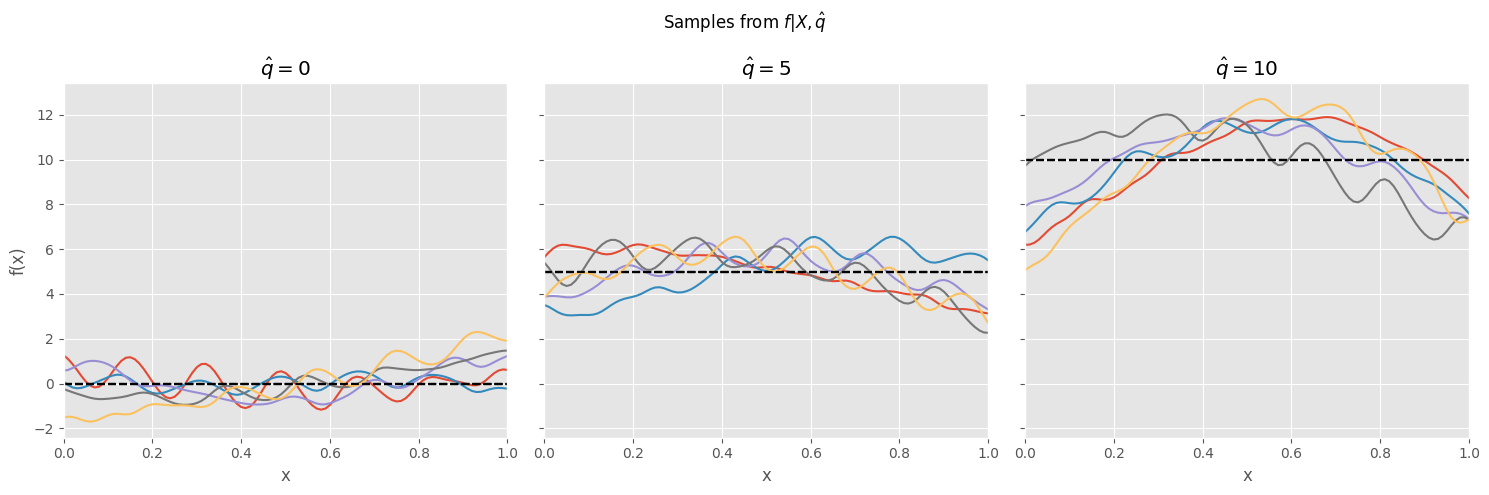

In [9]:
# Number of samples to draw
n_samples = 5

# Compute kernel matrix for $x_i = \frac{i-1}{l-1}$ and $x_j = \frac{j-1}{l-1}$
Kx = compute_kernel_matrix(kernel, x, x)

# Share x-axis and y-axis for better comparison
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for i, q_hat in enumerate([0, 5, 10]):
    # Compute mean and covariance of the conditional distribution given $X$ and $\hat{q}$
    Kx_w = Kx @ w  # called $\Sigma_{f\hat{q}}$ in deleverable 1
    w_Kx_w = w @ Kx_w  # called $\Sigma_{\hat{q}f}$

    # These are the formulas derived for deliverable 1
    mu = Kx_w / w_Kx_w * q_hat
    cov = Kx - np.outer(Kx_w / w_Kx_w, Kx_w)

    # inverse of the covariance matrix
    foo = np.linalg.inv(cov)

    L = scipy.linalg.cholesky(cov + 1e-10 * np.eye(len(x)), lower=True)

    # Draw samples from the conditional distribution
    for _ in range(n_samples):
        sample = mu + L @ np.random.normal(0, 1, len(x))
        ax[i].plot(x, sample)
        ax[i].hlines(q_hat, 0, 1, colors="black", linestyles="--")

        # print(np.sum(sample * w))

    ax[i].set(title=r"$\hat{q}=$" + f"{q_hat}", xlabel="x", xlim=(0, 1))
    if i == 0:
        ax[i].set(ylabel="f(x)")

fig.suptitle(r"Samples from $f | X, \hat{q}$ ")
plt.tight_layout()
plt.savefig("./figures/samples_f_given_X_q.png", dpi=600)
plt.show()


## Plots of posterior $f\vert\mathcal{D}$

In [380]:
def g(x):
    return -(np.sin(6 * np.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 3 / 2


### Observations in dataset $\mathcal{D}$

In [381]:
Dx = np.array([0, 0.25, 0.5])
Dy = np.array([1.46, 0.93, 2.76])

In [382]:
# Kernel matrix for the observations + noise for the diagonal - for numerical stability when inverting
KD = compute_kernel_matrix(kernel, Dx, Dx) + np.eye(len(Dx)) * 0.01
# Inverse kernel matrix following notations from lecture slides
G = np.linalg.inv(KD)
alpha = G @ Dy

# Cross-covariance between grid and observations
KxDx = compute_kernel_matrix(kernel, Dx, x)


In [383]:
# Posterior mean and covariance without constraint
# These are the formulas from slide 28 on GPs by Oswin Krause
mu_fD = KxDx.T @ alpha
sigma_fD = Kx - KxDx.T @ G @ KxDx


In [384]:
# Cholesky decomposition used sampling as hinted in exam text
# add jitter for numerical stability
L_fD = scipy.linalg.cholesky(sigma_fD + 1e-5 * np.eye(len(x)), lower=True)


In [385]:
# 5 samples from the posterior f|D
samples_fD = [mu_fD + L_fD @ np.random.normal(size=len(x)) for _ in range(n_samples)]
std_fD = np.sqrt(np.diag(sigma_fD))


### Plotting the mean and samples for f|D

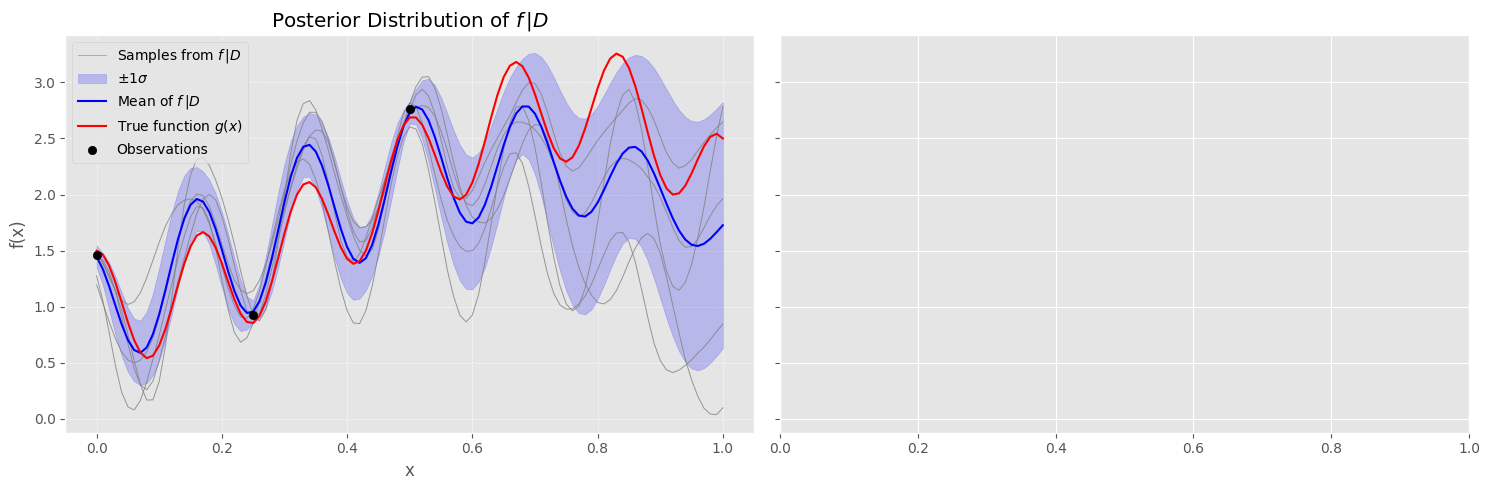

In [386]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(15, 5), sharey=True, tight_layout=True
)

# Plot sample functions with lighter colors and no labels
for sample in samples_fD:
    ax[0].plot(x, sample, color="gray", lw=0.7, alpha=0.8)

# Plot the ±1σ interval with transparency
ax[0].fill_between(
    x, mu_fD - std_fD, mu_fD + std_fD, color="blue", alpha=0.2, label=r"$\pm 1\sigma$"
)

# Plot the mean function
ax[0].plot(x, mu_fD, label=r"Mean of $f\, \vert D$", linewidth=1.5, color="blue")

# Plot the true function
ax[0].plot(x, g(x), color="red", linewidth=1.5, label=r"True function $g(x)$")

# Plot observations
ax[0].scatter(Dx, Dy, color="black", marker="o", label="Observations", zorder=5)

# Add axis labels
ax[0].set_xlabel("x")
ax[0].set_ylabel("f(x)")

# Add title
ax[0].set_title(r"Posterior Distribution of $f\, \vert D$")

# Add grid
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.8)

# Simplify legend
handles, labels = ax[0].get_legend_handles_labels()
# Replace individual sample labels with a single entry
sample_line = plt.Line2D([0], [0], color="gray", lw=0.5, alpha=0.8)
new_handles = [sample_line] + handles
new_labels = [r"Samples from $f\, \vert D$"] + labels
ax[0].legend(new_handles, new_labels, loc="upper left")

# plt.close(fig)

In [387]:
# Now adjust for the linear constraint w f = 2 = q
q_hat = 2
# This is the covariance between the Gaussian process and the linear constraint
v = sigma_fD @ w.reshape(-1, 1)
# Variance of the linear constraint
qhat_var = w @ v


In [388]:
# Difference between the desired constraint value and the expected value under the current model.
delta = q_hat - w @ mu_fD

In [389]:
# Compute K = v / c_var
K_const = v / qhat_var  # n x 1 vector


In [390]:
# Update mean
mu_qhat = mu_fD + K_const.flatten() * delta

# Update covariance
sigma_qhat = sigma_fD - (v @ v.T) / qhat_var

# Cholesky decomposition used sampling as hinted in exam text
# add jitter for numerical stability
L_fDq = scipy.linalg.cholesky(sigma_qhat + 1e-5 * np.eye(len(x)), lower=True)


# Samples from the adjusted Gaussian process
samples_fDq = [
    mu_qhat + L_fDq @ np.random.normal(size=len(x)) for _ in range(n_samples)
]

std_fDq = np.sqrt(np.diag(sigma_qhat))

### Plot the mean and samples for $f \vert \hat{q}, \mathcal{D}$

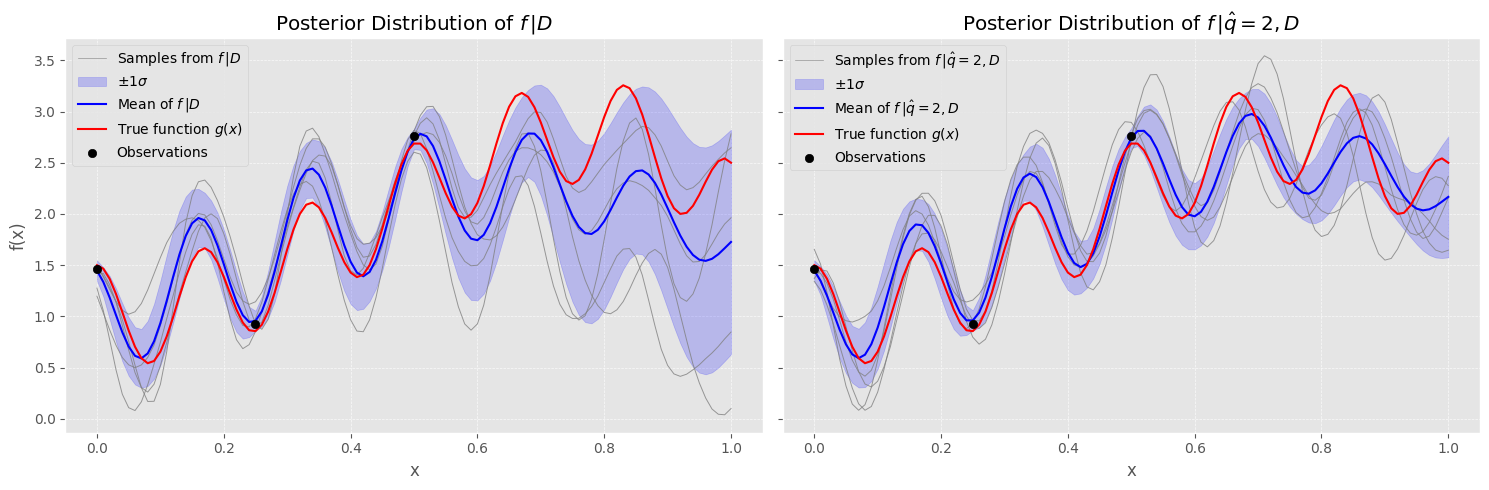

In [391]:
for sample in samples_fDq:
    ax[1].plot(x, sample, color="gray", lw=0.7, alpha=0.8)

# Plot the ±1σ interval with transparency
ax[1].fill_between(
    x,
    mu_qhat - std_fDq,
    mu_qhat + std_fDq,
    color="blue",
    alpha=0.2,
    label=r"$\pm 1\sigma$",
)

# Plot the mean function
ax[1].plot(
    x, mu_qhat, label=r"Mean of $f\, \vert \hat{q}=2,D$", linewidth=1.5, color="blue"
)

# Plot the true function
ax[1].plot(x, g(x), color="red", linewidth=1.5, label=r"True function $g(x)$")

# Plot observations
ax[1].scatter(Dx, Dy, color="black", marker="o", label="Observations", zorder=5)

# Add axis labels
ax[1].set_xlabel("x")
# ax[1].set_ylabel("f(x)")

# Add title
ax[1].set_title(r"Posterior Distribution of $f\, \vert \hat{q}=2,D$")

# Add grid
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.8)

# Simplify legend
handles, labels = ax[1].get_legend_handles_labels()
# Replace individual sample labels with a single entry
sample_line = plt.Line2D([0], [0], color="gray", lw=0.5, alpha=0.8)
new_handles = [sample_line] + handles
new_labels = [r"Samples from $f\, \vert \hat{q}=2, D$"] + labels
ax[1].legend(new_handles, new_labels, loc="upper left")
# plt.savefig("./figures/posterior_f_given_q_D.png", dpi=600)
plt.show()
fig